## 範例重點

學習如何在 keras 中加入 reduce learning rate

知道如何設定 reduce_lr 的監控目標

比較使用有無使用 reduce_lr 時的 performance

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss
"""
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

W0725 08:51:36.913946 4605392320 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 08:51:36.957722 4605392320 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 08:51:36.986650 4605392320 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 08:51:37.097234 4605392320 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.p

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

W0725 08:51:37.482377 4605392320 deprecation.py:323] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 128us/step - loss: 2.2293 - acc: 0.2648 - val_loss: 2.1160 - val_acc: 0.3200
Epoch 2/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.7561 - acc: 0.3888 - val_loss: 1.8284 - val_acc: 0.3750
Epoch 3/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.6319 - acc: 0.4297 - val_loss: 1.6862 - val_acc: 0.4115
Epoch 4/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.5601 - acc: 0.4549 - val_loss: 1.6291 - val_acc: 0.4272
Epoch 5/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.5038 - acc: 0.4748 - val_loss: 1.5884 - val_acc: 0.4422
Epoch 6/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.4580 - acc: 0.4914 - val_loss: 1.5554 - val_acc: 0.4546
Epoch 7/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.4183 - acc: 0.5067 - val_loss: 1.5331 - v

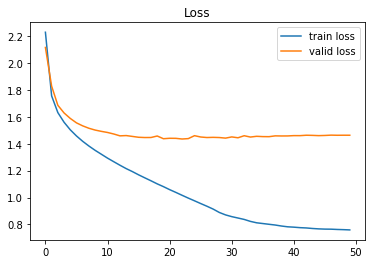

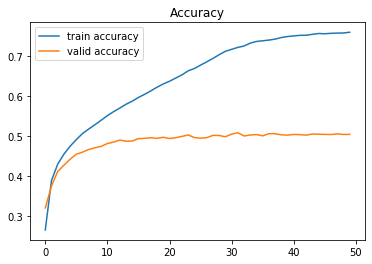

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work

請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響

請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [10]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [11]:
train, test = keras.datasets.cifar10.load_data()

In [12]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [13]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [15]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    Code Here
    建立你的神經網路
    """
    # input
    input_layer = keras.layers.Input(input_shape)
    
    # hidden
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    # output
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
LEARNING_RATE = 1e-3
EPOCHS = 5  # 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [17]:
"""
Code Here
建立實驗的比較組合
"""

# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0, 0.25, 0.5, 0.8]
redice_lr_patient = [5, 20]

In [18]:
import itertools


# Collect results
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    
    # build model
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    # compile
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    # 設定 callback function (about reducing learning rate)
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    """
    ReduceLROnPlateau	當指標變化小時，減少學習率(reduce learning rate) 	ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

    原文：https://blog.csdn.net/zzulp/article/details/76591341 
    """

    reduce_lr = ReduceLROnPlateau(factor = reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience = reduce_patient, 
                                  verbose=1)

    
    # fit
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.00, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

Epoch 2/5
50000/50000 [==============================] - 8s 164us/step - loss: 1.7402 - acc: 0.3931 - val_loss: 1.7954 - val_acc: 0.3804
Epoch 3/5
50000/50000 [==============================] - 7s 132us/step - loss: 1.6147 - acc: 0.4355 - val_loss: 1.6661 - val_acc: 0.4121
Epoch 4/5
50000/50000 [==============================] - 6s 114us/step - loss: 1.5415 - acc: 0.4627 - val_loss: 1.6326 - val_acc: 0.4325
Epoch 5/5
50000/50000 [==============================] - 5s 106us/step - loss: 1.4844 - acc: 0.4823 - val_loss: 1.5755 - val_acc: 0.4474
Numbers of exp: 4, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 8s 156us/step - loss: 2.2252 - acc: 0.2639 - val_loss: 2.1255 - val_acc: 0.3023
Epoch 2/5
50000/50000 [==============================] - 6s 125us/step - loss: 1.7558 - acc: 0.3908 - val_loss: 1.8432 - val_acc: 0.3761
Epoch 3/5
50000/50000 [==============================] - 6s 116us/step - loss: 1.6266 - acc: 0.4328 - val_loss: 1.6969 - val_acc: 0.4132
Epoch 4/5
50000/50000 [==============================] - 6s 117us/step - loss: 1.5543 - acc: 0.4592 - val_loss: 1.6333 - val_acc: 0.4288
Epoch 5/5
50000/50000 [==============================] - 6s 127us/step - loss: 1.4993 - acc: 0.4763 - val_loss: 1.5968 - val_acc: 0.4410
Numbers of exp: 8, reduce_factor: 0.00, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 7s 148us/step - loss: 1.8019 - acc: 0.3657 - val_loss: 1.7535 - val_acc: 0.3960
Epoch 2/5
50000/50000 [==============================] - 5s 107us/step - loss: 1.5549 - acc: 0.4485 - val_loss: 1.6141 - val_acc: 0.4225
Epoch 3/5
50000/50000 [==============================] - 5s 108us/step - loss: 1.4618 - acc: 0.4804 - val_loss: 1.5564 - val_acc: 0.4467 loss: 1 - ETA: 0s - loss: 1.4650 - acc: 0.4
Epoch 4/5
50000/50000 [==============================] - 5s 110us/step - loss: 1.3951 - acc: 0.5032 - val_loss: 1.6215 - val_acc: 0.4184
Epoch 5/5
50000/50000 [==============================] - 6s 117us/step - loss: 1.3369 - acc: 0.5245 - val_loss: 1.5920 - val_acc: 0.4240
Numbers of exp: 12, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 8s 157us/step - loss: 1.8337 - acc: 0.3541 - val_loss: 1.7886 - val_acc: 0.3809
Epoch 2/5
50000/50000 [==============================] - 5s 107us/step - loss: 1.5794 - acc: 0.4348 - val_loss: 1.6438 - val_acc: 0.4085
Epoch 3/5
50000/50000 [==============================] - 6s 116us/step - loss: 1.4841 - acc: 0.4706 - val_loss: 1.6890 - val_acc: 0.4014
Epoch 4/5
50000/50000 [==============================] - 6s 112us/step - loss: 1.4172 - acc: 0.4945 - val_loss: 1.5985 - val_acc: 0.4272
Epoch 5/5
50000/50000 [==============================] - 6s 112us/step - loss: 1.3598 - acc: 0.5154 - val_loss: 1.6139 - val_acc: 0.4218
Numbers of exp: 16, reduce_factor: 0.00, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 3072)              0         
________

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 8s 162us/step - loss: 1.8102 - acc: 0.3718 - val_loss: 2.1943 - val_acc: 0.2723
Epoch 2/5
50000/50000 [==============================] - 5s 105us/step - loss: 1.5389 - acc: 0.4529 - val_loss: 1.9787 - val_acc: 0.3312
Epoch 3/5
50000/50000 [==============================] - 5s 107us/step - loss: 1.4324 - acc: 0.4941 - val_loss: 2.2894 - val_acc: 0.3021
Epoch 4/5
50000/50000 [==============================] - 5s 107us/step - loss: 1.3640 - acc: 0.5175 - val_loss: 1.8818 - val_acc: 0.3604 0.5
Epoch 5/5
50000/50000 [==============================] - 5s 110us/step - loss: 1.2999 - acc: 0.5385 - val_loss: 2.0715 - val_acc: 0.2906
Numbers of exp: 20, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
____

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 9s 172us/step - loss: 1.8096 - acc: 0.3696 - val_loss: 5.3484 - val_acc: 0.1470
Epoch 2/5
50000/50000 [==============================] - 5s 108us/step - loss: 1.5385 - acc: 0.4544 - val_loss: 2.3012 - val_acc: 0.2508
Epoch 3/5
50000/50000 [==============================] - 5s 107us/step - loss: 1.4337 - acc: 0.4943 - val_loss: 2.5191 - val_acc: 0.2476
Epoch 4/5
50000/50000 [==============================] - 5s 110us/step - loss: 1.3612 - acc: 0.5195 - val_loss: 1.9511 - val_acc: 0.3451
Epoch 5/5
50000/50000 [==============================] - 5s 108us/step - loss: 1.2974 - acc: 0.5416 - val_loss: 2.0391 - val_acc: 0.3114: 3s - loss: 1.2922 - acc: - ETA: 2s - loss: 1 - ETA: 0s - loss: 1.2973 - acc


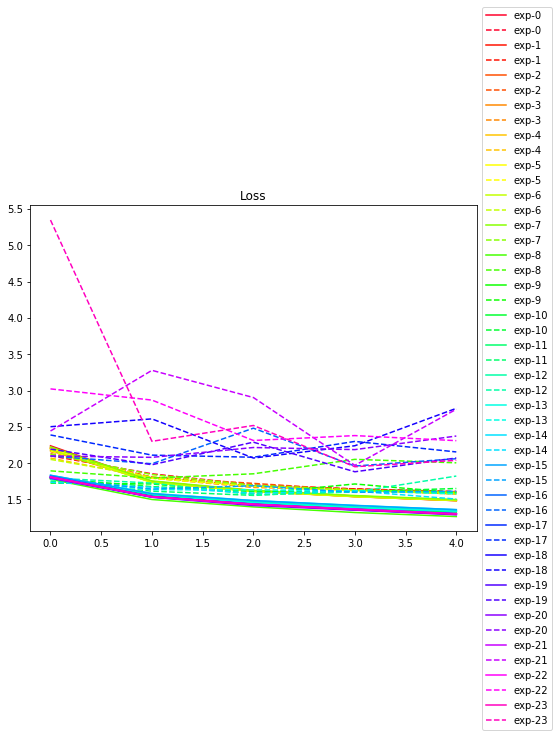

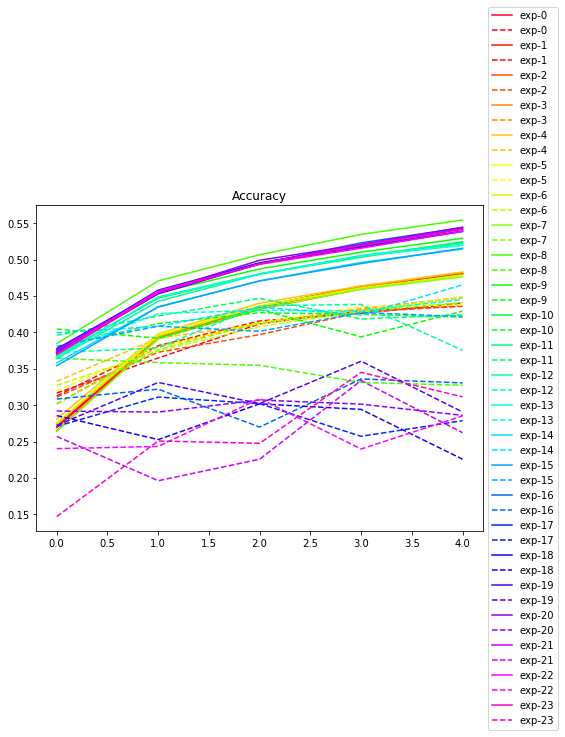

In [19]:
# Plot results
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

# 顏色數 要和前面的 嘗試參數組合數 一樣
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

# plot - loss
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# plot - acc
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()